# Ocular Disease Recognition project

# information about this data
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

*   Normal (N)
*   Diabetes (D)

*   Glaucoma (G)

*   Cataract (C),
*   Age related Macular Degeneration (A),

*   Hypertension (H)

*  Pathological Myopia (M),

*   Other diseases (O)
   




# import needed libraries

In [ ]:
# her we have the core libraries
import numpy as np
import pandas as pd
import os
import cv2
from collections import Counter
# and her the visulization one
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

# her we have the machine learning and preprocessing things
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
# the tensorflow and keras for the CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD , Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121, VGG16, InceptionV3
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

#imahe processing
from PIL import Image
import albumentations as A
# utility Libraries
import time
import logging
import gc
# system Librarie
import sys

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# load the data

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
from zipfile import ZipFile
file_name = "/content/ocular-disease-recognition-odir5k.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 99% 1.61G/1.62G [00:11<00:00, 194MB/s]
100% 1.62G/1.62G [00:11<00:00, 151MB/s]
Done


In [ ]:
df = pd.read_csv("/content/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
nested_odir_path = '/content/ODIR-5K'

main_files = os.listdir(nested_odir_path)
print("Main ODIR-5K folder contents:")
print(main_files)

# List the contents of the testing_images and training_images folders
testing_images_path = os.path.join(nested_odir_path, '/content/ODIR-5K/ODIR-5K/Testing Images')
training_images_path = os.path.join(nested_odir_path, '/content/ODIR-5K/ODIR-5K/Training Images')

print("\nTesting images folder contents:")
print(os.listdir(testing_images_path)[:10])  # Display first 10 files/directories

print("\nTraining images folder contents:")
print(os.listdir(training_images_path)[:10])

Main ODIR-5K folder contents:
['ODIR-5K']

Testing images folder contents:
['1684_left.jpg', '1648_right.jpg', '1199_left.jpg', '4755_left.jpg', '1193_right.jpg', '4075_right.jpg', '4145_right.jpg', '988_left.jpg', '1322_left.jpg', '2249_right.jpg']

Training images folder contents:
['440_right.jpg', '4427_left.jpg', '1092_left.jpg', '1561_left.jpg', '4467_right.jpg', '3107_right.jpg', '60_right.jpg', '656_left.jpg', '697_left.jpg', '4582_right.jpg']


In [ ]:
preprocessed_path = "/content/preprocessed_images"
preprocessed_files = os.listdir(preprocessed_path)
print(f"Number of files in preprocessed_images folder: {len(preprocessed_files)}")

# Display first few files
print("Sample files from preprocessed_images folder:")
print(preprocessed_files[:10])

Number of files in preprocessed_images folder: 6392
Sample files from preprocessed_images folder:
['4427_left.jpg', '1092_left.jpg', '1561_left.jpg', '4467_right.jpg', '3107_right.jpg', '60_right.jpg', '697_left.jpg', '4582_right.jpg', '2803_right.jpg', '2380_right.jpg']


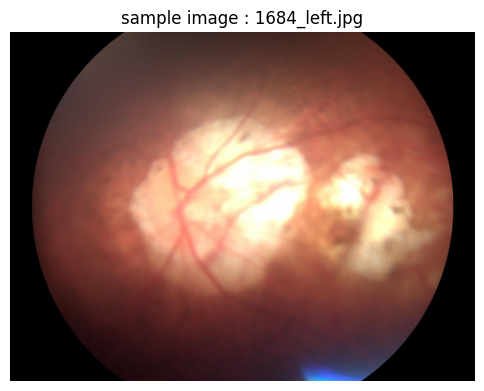

In [ ]:
def get_image_file_path(directory):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            return file_path
    return None

# get a valid image file path from testing_images
sample_testing_image_path = get_image_file_path(testing_images_path)
if sample_testing_image_path:
    sample_testing_image = Image.open(sample_testing_image_path)

    plt.figure(figsize=(6,6))
    plt.imshow(sample_testing_image)
    plt.title(f"sample image : {os.path.basename(sample_testing_image_path)}")
    plt.axis('off')
    plt.show()
else:
    print("no valid image files found in testing_images")

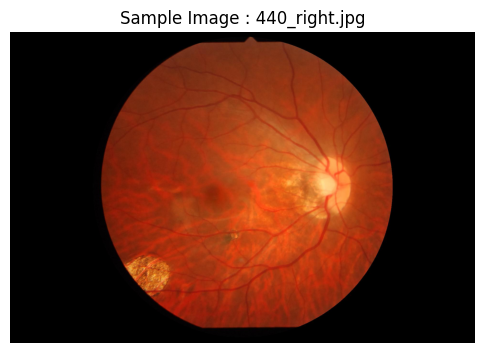

In [ ]:
# get a valid image file path from training_images
sample_training_image_path = get_image_file_path(training_images_path)
if sample_training_image_path:
    sample_training_image = Image.open(sample_training_image_path)

    plt.figure(figsize=(6,6))
    plt.imshow(sample_training_image)
    plt.title(f"Sample Image : {os.path.basename(sample_training_image_path)}")
    plt.axis('off')
    plt.show()
else:
    print("No valid image files found in training_images")

the image from ODIR-5K


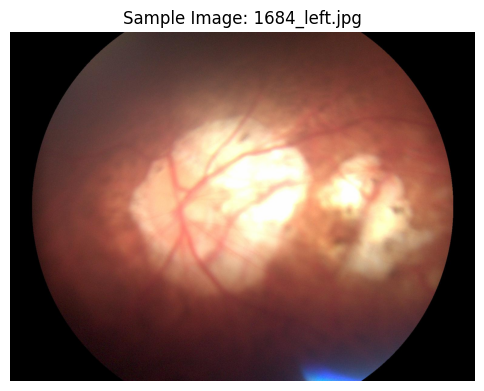

the image from preprocessed_image


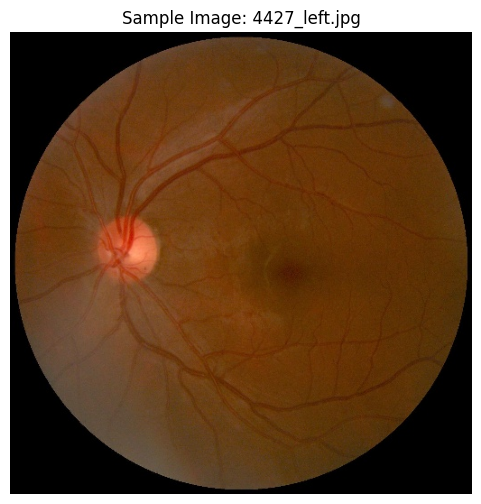

In [ ]:
# her we compaer a sample image from the odire-5k and a sample image from prepeocesses_images to see the difrence
def display_sample_image(folder_path, file_name):

    file_path = os.path.join(folder_path, file_name)
    image = Image.open(file_path)

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Sample Image: {file_name}")
    plt.axis('off')
    plt.show()

# Display a sample image from ODIR-5K
print("the image from ODIR-5K")
sample_odir_image = os.listdir(testing_images_path)[0]
display_sample_image(testing_images_path, sample_odir_image)

# Display a sample image from preprocessed_images
print("the image from preprocessed_image")
sample_preprocessed_image = os.listdir(preprocessed_path)[0]
display_sample_image(preprocessed_path, sample_preprocessed_image)

# analysis and visulization on the data

In [ ]:
# starting with the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [ ]:
df.isna().sum()

,0
ID,0
Patient Age,0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,0
D,0
G,0


In [ ]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df['Left-Diagnostic Keywords'].nunique()

196

In [ ]:
df['Right-Diagnostic Keywords'].nunique()

205

In [ ]:
df['Left-Diagnostic Keywords'].value_counts()

,count
Left-Diagnostic Keywords,
normal fundus,2796
moderate non proliferative retinopathy,717
mild nonproliferative retinopathy,428
cataract,268
pathological myopia,208
...,...
fundus laser photocoagulation spots,1
retinal pigment epithelium atrophy，diabetic retinopathy,1
white vessel，suspected glaucoma,1


In [ ]:
df['Right-Diagnostic Keywords'].value_counts()

,count
Right-Diagnostic Keywords,
normal fundus,2705
moderate non proliferative retinopathy,745
mild nonproliferative retinopathy,472
cataract,250
pathological myopia,216
...,...
retinochoroidal coloboma，epiretinal membrane,1
vitreous degeneration，lens dust,1
retinal pigment epithelial hypertrophy，moderate non proliferative retinopathy,1


In [ ]:
#diseas frewuency on left eye
# it also show the classes imbalanety
left_diagnosis_counts = df['Left-Diagnostic Keywords'].value_counts()
fig_left = px.bar(
    x=left_diagnosis_counts.index,
    y=left_diagnosis_counts.values,
    labels={'x': 'Left Eye Diagnosis', 'y': 'Count'},
    title='Distribution of Left Eye Diagnoses'
)
fig_left.show()

# and her on the right wyw
right_diagnosis_counts = df['Right-Diagnostic Keywords'].value_counts()
fig_right = px.bar(
    x=right_diagnosis_counts.index,
    y=right_diagnosis_counts.values,
    labels={'x': 'Right Eye Diagnosis', 'y': 'Count'},
    title='Distribution of Right Eye Diagnoses'
)
fig_right.show()
# normal fundes has the most number in the distrupution in both eyes

In [ ]:
# create a DataFrame for comparison
df_comparison = df[['Left-Diagnostic Keywords', 'Right-Diagnostic Keywords']].copy()
df_comparison['Both_Eyes_Same'] = df_comparison['Left-Diagnostic Keywords'] == df_comparison['Right-Diagnostic Keywords']

# create a bar plot to show the count of matching vs. differing diagnoses
comparison_counts = df_comparison['Both_Eyes_Same'].value_counts()
fig_comparison = px.bar(
    x=comparison_counts.index,
    y=comparison_counts.values,
    labels={'x': 'Diagnoses Match', 'y': 'Count'},
    title='Count of Matching vs. Differing Diagnoses (Left vs. Right Eye)'
)
fig_comparison.show()
# true if they have the same eye diagnosis fals if not

In [ ]:
df_comparison

,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Both_Eyes_Same
0,cataract,normal fundus,False
1,normal fundus,normal fundus,True
2,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,False
3,macular epiretinal membrane,mild nonproliferative retinopathy,False
4,moderate non proliferative retinopathy,moderate non proliferative retinopathy,True
...,...,...,...
6387,severe nonproliferative retinopathy,proliferative diabetic retinopathy,False
6388,moderate non proliferative retinopathy,moderate non proliferative retinopathy,True
6389,mild nonproliferative retinopathy,normal fundus,False
6390,mild nonproliferative retinopathy,mild nonproliferative retinopathy,True


In [ ]:
#see the  Distribution of Age
fig = px.histogram(
    df,
    x='Patient Age',
    nbins=30,
    title='Distribution of Age'
)
# the age is more between 60 to 64
fig.show()

# make a catter of the relation between the age and the patient sex

fig = px.scatter(
        df,
        x='Patient Age',
        y='Patient Sex',
        color='Left-Diagnostic Keywords', # on left eye
        title='Age vs. sex by Diagnosis'
    )
fig.show()

fig = px.scatter(
        df,
        x='Patient Age',
        y='Patient Sex',
        color='Right-Diagnostic Keywords', # on the right eye
        title='Age vs. sex by Diagnosis'
    )
fig.show()

In [ ]:
# visulize the distribution of image size on the train images
def get_image_sizes(image_folder): # the function read the image size
    sizes = []
    for file_name in os.listdir(image_folder):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            with Image.open(os.path.join(image_folder, file_name)) as img:
                sizes.append(img.size)
    return sizes

# Get sizes from training images
image_sizes = get_image_sizes('/content/ODIR-5K/ODIR-5K/Testing Images')
sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Plot image sizes distribution
fig = px.histogram(sizes_df, x='Width', nbins=30, title='Distribution of Image Widths')
fig.add_trace(px.histogram(sizes_df, x='Height', nbins=30).data[0])
fig.update_layout(xaxis_title='Pixel Value', yaxis_title='Frequency', barmode='overlay')
fig.show()
# images have difrent size

In [ ]:
#  made analysis and visulization on the color distribution
# function to get color distribution
import random
def get_sampled_color_distribution(image_folder, num_images=100, pixels_per_image=1000):
    colors = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sampled_files = random.sample(image_files, min(num_images, len(image_files)))

    for file_name in sampled_files:
        with Image.open(os.path.join(image_folder, file_name)) as img:
            img = img.convert('RGB')
            np_image = np.array(img)
            # Flatten the image to 2D and sample pixels
            sampled_pixels = np_image.reshape(-1, 3)
            sampled_pixels = sampled_pixels[random.sample(range(sampled_pixels.shape[0]), min(pixels_per_image, sampled_pixels.shape[0]))]
            colors.extend(sampled_pixels)

    return np.array(colors)

# Get color distribution from a sample of images
sampled_colors = get_sampled_color_distribution('/content/ODIR-5K/ODIR-5K/Training Images')

mean_colors = np.mean(sampled_colors, axis=0)
std_colors = np.std(sampled_colors, axis=0)

# Plot the color distribution
fig = go.Figure()
fig.add_trace(go.Bar(x=['Red', 'Green', 'Blue'], y=mean_colors, name='Mean Color Intensity'))
fig.add_trace(go.Bar(x=['Red', 'Green', 'Blue'], y=std_colors, name='Color Intensity Std Dev', opacity=0.6))
fig.update_layout(yaxis_title='Color Intensity', title='Color Distribution of Sampled Images')
fig.show()

In [ ]:
# the correltion matrix between the age and the both eyes diagnoses
encoded_df = df.copy()

# Encoding the diagnosis columns
encoded_df['Left-Diagnostic Keywords'] = pd.factorize(encoded_df['Left-Diagnostic Keywords'])[0]
encoded_df['Right-Diagnostic Keywords'] = pd.factorize(encoded_df['Right-Diagnostic Keywords'])[0] # make factorize to change the catagorical value to encoded numerical value so it can be processed and plot

# Compute correlation matrix
correlation_matrix = encoded_df[['Patient Age', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords']].corr()

# Plot correlation heatmap
fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale='RdBu_r',
                title='Correlation Heatmap Between Age and Diagnoses')
fig.show()

In [ ]:
# making a sankey diagram between the most 5 commen dignosis
# in this case her the diagram foucuse on the flow of diagnosis between the left and right eyes
top_left_diagnoses = df['Left-Diagnostic Keywords'].value_counts().nlargest(5).index
top_right_diagnoses = df['Right-Diagnostic Keywords'].value_counts().nlargest(5).index # her we have the most 5 commen diagnosis

# Filter the dataset to include only these diagnoses
filtered_df = df[(df['Left-Diagnostic Keywords'].isin(top_left_diagnoses)) &
                      (df['Right-Diagnostic Keywords'].isin(top_right_diagnoses))] # her we filter the data to have only this 5 diagnosis

# Prepare data for Sankey diagram
left_labels = filtered_df['Left-Diagnostic Keywords'].unique().tolist()
right_labels = filtered_df['Right-Diagnostic Keywords'].unique().tolist()

labels = left_labels + right_labels
source = filtered_df['Left-Diagnostic Keywords'].apply(lambda x: labels.index(x)).tolist()
target = filtered_df['Right-Diagnostic Keywords'].apply(lambda x: labels.index(x) + len(left_labels)).tolist()
values = [1] * len(filtered_df) # represent te 1 example

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.2),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
))

fig.update_layout(title_text="Simplified Sankey Diagram of Diagnosis Flow Between Left and Right Eyes", font_size=10)
fig.show()

In [ ]:
filtered_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,4682,45,Male,4682_left.jpg,4682_right.jpg,mild nonproliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4682_left.jpg
6386,4683,58,Male,4683_left.jpg,4683_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",4683_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg


In [ ]:
# some cool animation on the data features
px.scatter(filtered_df , x = "Left-Diagnostic Keywords"	, y = "Right-Diagnostic Keywords", color = "Patient Sex", animation_frame="Patient Age"
, template= "plotly_dark")

# data prepration and handling

In [ ]:
# # classification of the deiseses
# the custom function for  matching
def map_to_label_exact(keyword):
    if keyword == 'normal fundus':
        return 'Normal Fundus'
    elif keyword == 'retinopathy':
        return 'Diabetes'
    elif keyword == 'severe nonproliferative retinopathy':
        return 'Diabetes'
    elif keyword == 'cataract':
        return 'Cataract'
    elif keyword == 'moderate non proliferative retinopathy':
        return 'Diabetes'
    elif keyword == 'pathological myopia':
         return 'Pathological Myopia'
    elif keyword == 'dry age-related macular degeneration':
         return 'Age-related Macular Degeneration'
    elif keyword == 'glaucoma':
        return 'Glaucoma'
    elif keyword == 'drusen':
        return 'Drusen'
    elif keyword == 'hypertensive retinopathy':
         return 'Hypertension'
    else:
        return 'Other diseases/abnormalities'


In [ ]:
# apply the costum function to the right the left diagnosis
df['right_label_column'] = df['Right-Diagnostic Keywords'].apply(map_to_label_exact)
df['left_label_column'] = df['Left-Diagnostic Keywords'].apply(map_to_label_exact)


In [ ]:
# making for them a data fram
df_right_img = df[['Right-Diagnostic Keywords', 'right_label_column']]
df_left_img  = df[['Left-Diagnostic Keywords', 'left_label_column']]

In [ ]:
df_right_img

,Right-Diagnostic Keywords,right_label_column
0,normal fundus,Normal Fundus
1,normal fundus,Normal Fundus
2,moderate non proliferative retinopathy,Diabetes
3,mild nonproliferative retinopathy,Other diseases/abnormalities
4,moderate non proliferative retinopathy,Diabetes
...,...,...
6387,proliferative diabetic retinopathy,Other diseases/abnormalities
6388,moderate non proliferative retinopathy,Diabetes
6389,normal fundus,Normal Fundus
6390,mild nonproliferative retinopathy,Other diseases/abnormalities


In [ ]:
df_right_img = pd.concat([df_right_img, df[['Right-Fundus']]], axis=1) # concat the df we made with the image id
df_right_img.rename(columns={"right_label_column": "disease", "Right-Fundus": "image_id"}, inplace=True)
df_right_img.drop("Right-Diagnostic Keywords", axis=1, inplace=True) # drop the name
df_left_img = pd.concat([df_left_img, df[['Left-Fundus']]], axis=1) # make same thing with the left
df_left_img.rename(columns={"left_label_column": "disease", "Left-Fundus": "image_id"}, inplace=True)
df_labeled = pd.concat([df_right_img, df_left_img]) # but all in one data set
df_labeled.drop("Left-Diagnostic Keywords", axis=1, inplace=True)
df_labeled['disease'].value_counts()

,count
disease,
Normal Fundus,5501
Other diseases/abnormalities,3331
Diabetes,1748
Cataract,518
Pathological Myopia,424
Glaucoma,397
Age-related Macular Degeneration,388
Drusen,270
Hypertension,207


In [ ]:
df_labeled

,disease,image_id
0,Normal Fundus,0_right.jpg
1,Normal Fundus,1_right.jpg
2,Diabetes,2_right.jpg
3,Other diseases/abnormalities,4_right.jpg
4,Diabetes,5_right.jpg
...,...,...
6387,Diabetes,4686_left.jpg
6388,Diabetes,4688_left.jpg
6389,Other diseases/abnormalities,4689_left.jpg
6390,Other diseases/abnormalities,4690_left.jpg


In [ ]:
# have all the categories exept the categir that say another diseas
# reason that this class have all the classes that are not classified , so i removed as it may weak the model and make distruction as it even does not spacify and disease
df_labeled = df_labeled.loc[(df_labeled["disease"] == "Normal Fundus") | (df_labeled['disease'] == 'Cataract') | (df_labeled['disease'] == 'Diabetes') | (df_labeled['disease'] == 'Cataract') |
                           (df_labeled['disease'] == 'Pathological Myopia') | (df_labeled['disease'] == 'Glaucoma') | (df_labeled['disease'] == 'Age-related Macular Degeneration') | (df_labeled['disease'] == 'Drusen') |
                           (df_labeled['disease'] == 'Hypertension') ]

In [ ]:
df_labeled['disease'].value_counts() # our job her is done

,count
disease,
Normal Fundus,5501
Diabetes,1748
Cataract,518
Pathological Myopia,424
Glaucoma,397
Age-related Macular Degeneration,388
Drusen,270
Hypertension,207


In [ ]:
import shutil

In [ ]:
import shutil # import the shutil here
import os
# then now our goal is to store the lables images into its disease folder
main_dir = 'classified_images_new/train'
os.makedirs(main_dir, exist_ok = True)
# make subdirectores for the labels
labels = df_labeled['disease'].unique()
for label in labels:
    os.makedirs(os.path.join(main_dir, label), exist_ok=True)
# the images place
place_imgs = "/content/preprocessed_images"
# so her we copy the images to the folders
for index , row in df_labeled.iterrows():
    place_file = os.path.join(place_imgs, row["image_id"]) # this is the path for the images in the place_imgs directory
    label = row["disease"]
    im_folder = os.path.join(main_dir, label)
    im_files = os.path.join(im_folder, row["image_id"])
    if not os.path.isfile(place_file):
        print(f"File {place_imgs} does not exist.")
        continue

    shutil.copy2(place_file, im_files) # copy the file


In [ ]:
import random
train_dir = './classified_images_new/train'
test_dir = './classified_images_new/test'

# Create the test directory if it doesn't exist
os.makedirs(test_dir, exist_ok=True)

# making the test size to be 20 percent
test_size = 0.2

# iterate over each label folder in the train directory
for label_folder in os.listdir(train_dir):
    label_train_dir = os.path.join(train_dir, label_folder)
    label_test_dir = os.path.join(test_dir, label_folder)


    os.makedirs(label_test_dir, exist_ok=True)

    images = os.listdir(label_train_dir)

    # Shuffle the images
    random.shuffle(images)

    num_test_images = int(len(images) * test_size)


    test_images = images[:num_test_images]

    # her i move the test images to the test directory
    for image in test_images:
        src_path = os.path.join(label_train_dir, image)
        dst_path = os.path.join(label_test_dir, image)
        shutil.move(src_path, dst_path)

print("Test set created successfully.")

Test set created successfully.


In [ ]:
train_dir = './classified_images_new/train'
valid_dir = './classified_images_new/valid'

# Create the test directory if it doesn't exist
os.makedirs(valid_dir, exist_ok=True)

# making the test size to be 10 percent
valid_size = 0.1

# iterate over each label folder in the train directory
for label_folder in os.listdir(train_dir):
    label_train_dir = os.path.join(train_dir, label_folder)
    label_valid_dir = os.path.join(valid_dir, label_folder)


    os.makedirs(label_valid_dir, exist_ok=True)

    images = os.listdir(label_train_dir)

    # Shuffle the images
    random.shuffle(images)

    num_valid_images = int(len(images) * valid_size)


    valid_images = images[:num_test_images]

    # her i move the test images to the test directory
    for image in valid_images:
        src_path = os.path.join(label_train_dir, image)
        dst_path = os.path.join(label_valid_dir, image)
        shutil.move(src_path, dst_path)

print("Test set created successfully.")

Test set created successfully.


# data preprocessing and data augmentaion

In [ ]:
# balance data by oversampling stratgy
train_dir =  "/content/classified_images_new/train"
class_counts_train = {folder: len(os.listdir(os.path.join(train_dir, folder))) for folder in os.listdir(train_dir)}

print("Class counts:")
for label, count in class_counts_train.items(): # her we have the value of data in train is leed the the samples one if you found it the same this mean i run this cell after sampling
    # but the initial value if smaller than this
    print(f"{label}: {count} images")
    # 100% the data is not balanced

Class counts:
Pathological Myopia: 130 images
Hypertension: 32 images
Normal Fundus: 2201 images
Glaucoma: 108 images
Diabetes: 660 images
Age-related Macular Degeneration: 105 images
Drusen: 59 images
Cataract: 158 images


In [ ]:
test_dir = "/content/classified_images_new/test"
class_counts_test = {folder: len(os.listdir(os.path.join(test_dir, folder))) for folder in os.listdir(test_dir)}

print("Class counts:")
for label, count in class_counts_test.items():
    print(f"{label}: {count} images")

Class counts:
Pathological Myopia: 45 images
Hypertension: 20 images
Normal Fundus: 563 images
Glaucoma: 40 images
Diabetes: 177 images
Age-related Macular Degeneration: 39 images
Drusen: 27 images
Cataract: 52 images


In [ ]:
valid_dir = "/content/classified_images_new/valid"
class_counts_valid = {folder: len(os.listdir(os.path.join(valid_dir, folder))) for folder in os.listdir(valid_dir)}

print("Class counts:")
for label, count in class_counts_valid.items():
    print(f"{label}: {count} images")

Class counts:
Pathological Myopia: 52 images
Hypertension: 52 images
Normal Fundus: 52 images
Glaucoma: 52 images
Diabetes: 52 images
Age-related Macular Degeneration: 52 images
Drusen: 52 images
Cataract: 52 images


In [ ]:
# Define the target number of images for each class
max_count = max(class_counts_train.values())

for label, count in class_counts_train.items():
    if count < max_count:
        # Path to the label folder
        label_folder = os.path.join(train_dir, label)
        images = os.listdir(label_folder)
        # Duplicate images to reach the target count
        while len(images) < max_count:
            images.extend(images[:max_count - len(images)])
        # Shuffle the images
        np.random.shuffle(images)
        # Copy images to the label folder
        for image in images[count:]:
            src = os.path.join(label_folder, image)
            dst = os.path.join(label_folder, f"duplicated_{image}")
            shutil.copy2(src, dst)

In [ ]:
print("Class counts:")
for label, count in class_counts_train.items():
    print(f"{label}: {count} images")


Class counts:
Pathological Myopia: 130 images
Hypertension: 32 images
Normal Fundus: 2201 images
Glaucoma: 108 images
Diabetes: 660 images
Age-related Macular Degeneration: 105 images
Drusen: 59 images
Cataract: 158 images


In [ ]:
# resize images in train
target_size = (224, 224)

def resize_image(image_path, target_path):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img.save(target_path)

# Resize images in each folder
for label in class_counts_train.keys():
    label_folder = os.path.join(train_dir, label)
    for image_file in os.listdir(label_folder):
        src_path = os.path.join(label_folder, image_file)
        dst_path = os.path.join(label_folder, image_file)  # Overwrite the original file
        resize_image(src_path, dst_path)

In [ ]:
# resize the validatio set images
target_size = (224, 224)

def resize_image(image_path, target_path):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img.save(target_path)

# Resize images in each folder
for label in class_counts_valid.keys():
    label_folder = os.path.join(valid_dir, label)
    for image_file in os.listdir(label_folder):
        src_path = os.path.join(label_folder, image_file)
        dst_path = os.path.join(label_folder, image_file)  # Overwrite the original file
        resize_image(src_path, dst_path)

In [ ]:
# her i resize the test set images
target_size = (224, 224)

def resize_image(image_path, target_path):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img.save(target_path)

# Resize images in each folder
for label in class_counts_test.keys():
    label_folder = os.path.join(test_dir, label)
    for image_file in os.listdir(label_folder):
        src_path = os.path.join(label_folder, image_file)
        dst_path = os.path.join(label_folder, image_file)  # Overwrite the original file
        resize_image(src_path, dst_path)

In [ ]:
# normalize images
def normalize_image(image):
    # Convert image to float32 and normalize to [0, 1]
    image = image.astype('float32') / 255.0
    return image

def process_images_in_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            # Load image in grayscale
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            # Normalize image
            img_normalized = normalize_image(img)
            # Save the normalized image back
            cv2.imwrite(file_path, (img_normalized * 255).astype('uint8'))
process_images_in_directory(train_dir)
process_images_in_directory(valid_dir)
process_images_in_directory(test_dir)

In [ ]:
train_datagen = ImageDataGenerator( # data augmantation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/classified_images_new/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/classified_images_new/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/classified_images_new/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test set
)

Found 4696 images belonging to 8 classes.
Found 416 images belonging to 8 classes.
Found 963 images belonging to 8 classes.


# # fine tuning the pretrained model (EfficientNet80)

In [ ]:
from tensorflow.keras import layers, models,regularizers

eff = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Set all parameters as trainable
for layer in eff.layers:
    layer.trainable = True

# her i get  the number of input features for the fc layer
n_inputs = eff.output_shape[1]

# Redefine fc layer for the classification problem
eff_top = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),  # Adding Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),  # Adding Batch Normalization
    layers.GlobalAveragePooling2D(),  # Using GlobalAveragePooling
    layers.Dropout(0.5),

    # Fully Connected Layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Reduced units
    layers.Dropout(0.6),  # Increased dropout rate

    # Output Layer
    layers.Dense(8, activation='softmax')
])
# Concatenate Xception base model with the new top layers
model = models.Sequential([
    eff,
    eff_top
])

# Print model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 8)                   │         531,816 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,581,387 (17.48 MB)

 Trainable params: 4,539,044 (17.32 MB)

 Non-trainable params: 42,343 (165.41 KB)

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
model.compile(optimizer=Adam(learning_rate=3e-4,),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
# calback and fit the model
early_stopping_callback = EarlyStopping(
    monitor='loss',   # Monitor training loss
    patience=10,       # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the best epoch
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',          # Filepath to save the model
    monitor='val_accuracy',            # Metric to monitor
    save_best_only=True,               # Save only the model with the best accuracy
    save_weights_only=False,
    mode='max',
)

# Train the model with data augmentation and class weights
history = model.fit(train_generator,steps_per_epoch = (train_generator.samples // train_generator.batch_size),
                    epochs=2,  # Set a large number of epochs
                    validation_data=valid_generator,
                    callbacks=[early_stopping_callback,checkpoint_callback], verbose = 1)

Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 64s 422ms/step - accuracy: 0.9455 - loss: 0.3443 - val_accuracy: 0.5457 - val_loss: 2.6641
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.3563 - val_accuracy: 0.5361 - val_loss: 2.6844


In [ ]:
y_pred = []
for i in model.predict(test_generator):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


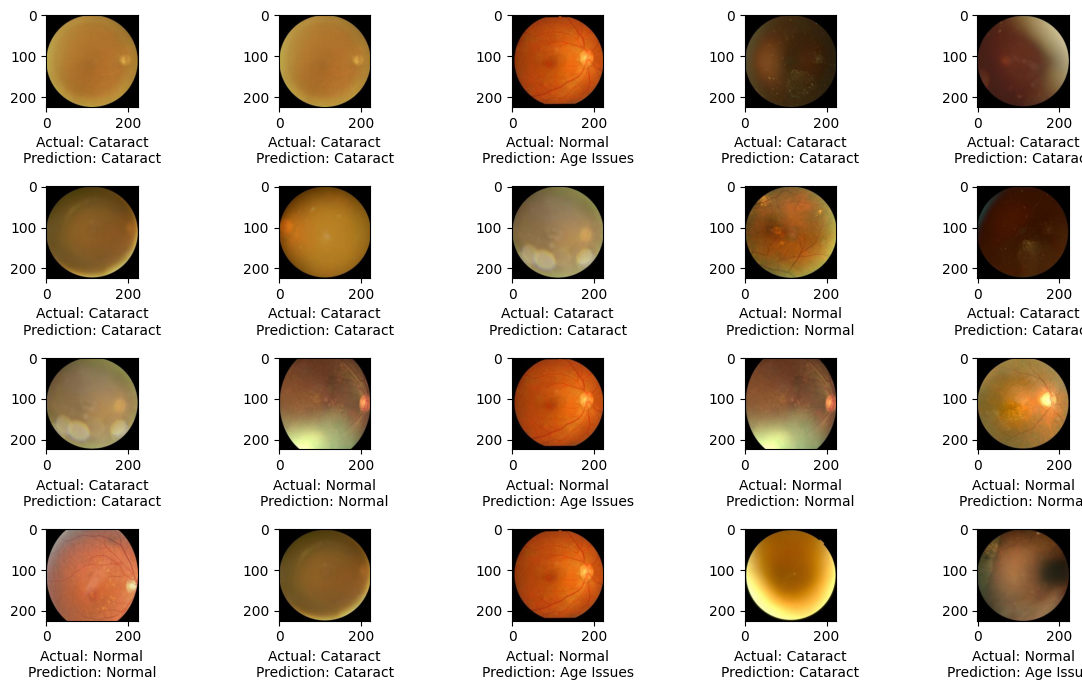

In [ ]:
# how model predict images
def get_label_from_index(index):
    labels = ["Normal", "Cataract", "Diabetes", "Glaucoma", "Hypertension", "Myopia", "Age Issues", "Other"]
    return labels[index]


x_batch, y_batch = next(test_generator)

# Predict the classes for the batch
y_pred = model.predict(x_batch)
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(12, 7))

for i in range(20):
    # Select a random index in the batch
    idx = random.choice(range(len(x_batch)))

    # Get the image and its true label and predicted label
    image = x_batch[idx]
    true_label = np.argmax(y_batch[idx])
    pred_label = y_pred_classes[idx]

    # Convert indices to class names
    true_label_name = get_label_from_index(true_label)
    pred_label_name = get_label_from_index(pred_label)

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"Actual: {true_label_name}\nPrediction: {pred_label_name}")

plt.tight_layout()
plt.show()

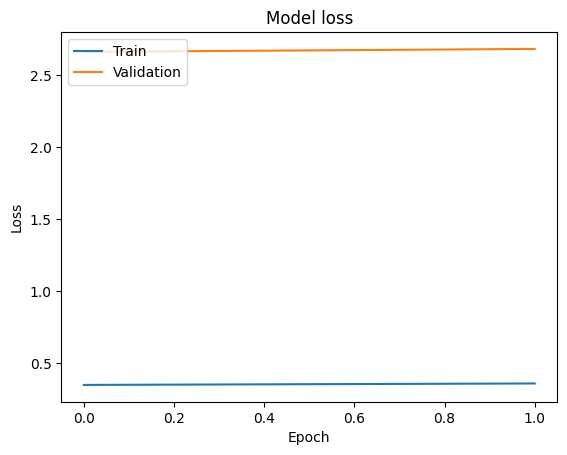

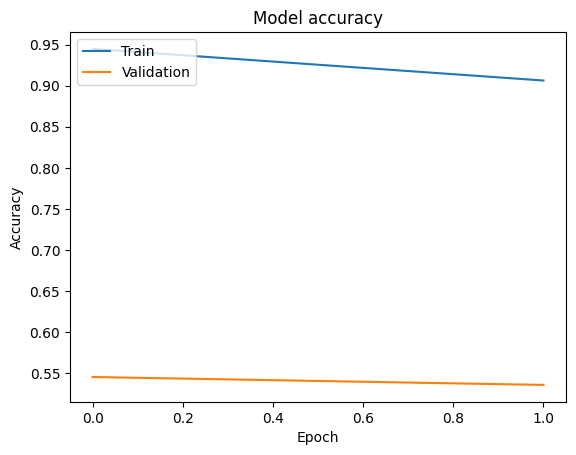

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6505 - loss: 1.7790
Loss: 1.4300320148468018
Accuracy: 0.7124999761581421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/ste

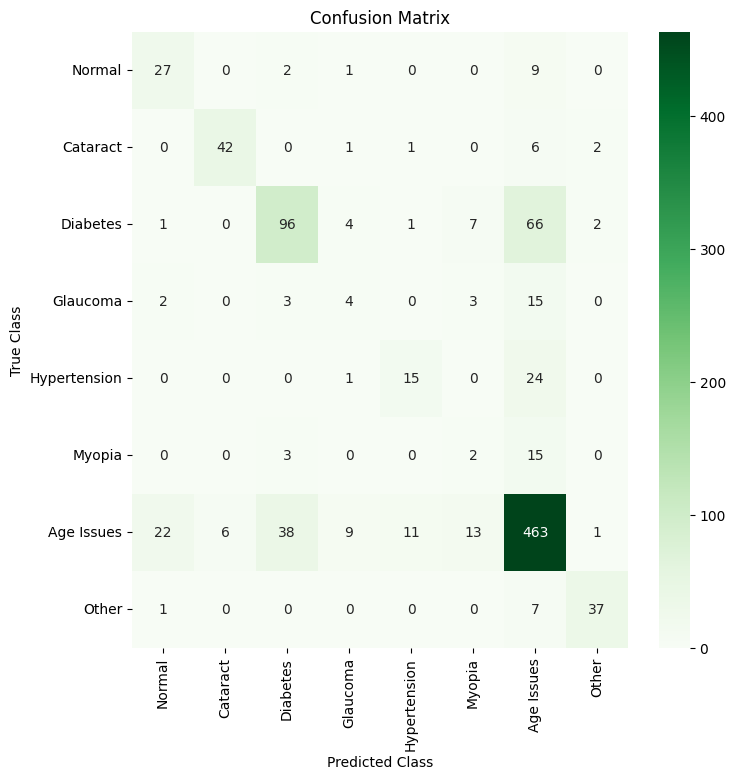

Total samples per class:
Normal: 39
Cataract: 52
Diabetes: 177
Glaucoma: 27
Hypertension: 40
Myopia: 20
Age Issues: 563
Other: 45


In [ ]:
def collect_labels_and_predictions(generator, model):
    true_labels = []
    pred_labels = []
    for batch_images, batch_labels in generator:
        # Predict batch
        batch_preds = model.predict(batch_images)
        # Get predicted classes
        batch_pred_classes = np.argmax(batch_preds, axis=1)
        # Get true classes
        batch_true_classes = np.argmax(batch_labels, axis=1)

        # Append to lists
        pred_labels.extend(batch_pred_classes)
        true_labels.extend(batch_true_classes)

        # Stop iteration if it's a test generator (use steps_per_epoch)
        if len(true_labels) >= generator.samples:
            break

    return np.array(true_labels), np.array(pred_labels)

# Evaluate the model using the generator
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Collect true labels and predictions
y_true_classes, y_pred_classes = collect_labels_and_predictions(test_generator, model)

# Class names (ensure this matches your model's output)
class_names = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertension', 'Myopia', 'Age Issues', 'Other']

# Generate and print classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

# Generate and plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Print the total number of samples for each class
class_counts = {name: np.sum(y_true_classes == idx) for idx, name in enumerate(class_names)}

print("Total samples per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

In [ ]:
# Save the model in HDF5 format
model.save('my_model.h5')
from google.colab import files

# Download the HDF5 model file
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import json
import pickle
from tensorflow.keras.models import model_from_json

# ===========================
# Part 1: Save the Model
# ===========================

# Assume `model` is your trained Keras model

# Create directory in Google Drive (if not already existing)
save_dir = '/content/drive/MyDrive/Major Project'
os.makedirs(save_dir, exist_ok=True)

# Save model architecture to JSON
model_json = model.to_json()
with open(f'{save_dir}/Major_Project.json', 'w') as json_file:
    json.dump(model_json, json_file)

# Save model weights to a pickle file
with open(f'{save_dir}/model_weights.pkl', 'wb') as weights_file:
    pickle.dump(model.get_weights(), weights_file)

print(f"Model architecture and weights saved in: {save_dir}")

# ===========================
# Part 2: Load the Model
# ===========================

# Load model architecture from JSON
with open(f'{save_dir}/Major_Project.json', 'r') as json_file:
    loaded_model_json = json.load(json_file)

# Recreate the model
model = model_from_json(loaded_model_json)

# Load model weights from pickle file
with open(f'{save_dir}/model_weights.pkl', 'rb') as weights_file:
    loaded_weights = pickle.load(weights_file)

# Set the weights in the model
model.set_weights(loaded_weights)

print("Model architecture and weights loaded successfully.")

# ===========================
# Verify the Model
# ===========================

# Print model summary to ensure everything is in place
model.summary()

# Test with dummy data (replace input shape as per your model)
import numpy as np
dummy_input = np.random.rand(1, 224, 224, 3)  # Adjust shape based on your model's input
predictions = model.predict(dummy_input)
print("Predictions on dummy input:", predictions)


Model architecture and weights saved in: /content/drive/MyDrive/Major Project
Model architecture and weights loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 8)                   │         531,816 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,120,433 (34.79 MB)

 Trainable params: 4,539,044 (17.32 MB)

 Non-trainable params: 42,343 (165.41 KB)

 Optimizer params: 4,539,046 (17.32 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Predictions on dummy input: [[3.5317566e-06 9.9907398e-01 7.4629199e-05 2.0777072e-05 6.8186564e-05
  9.6131635e-06 7.3327596e-04 1.5912130e-05]]


In [ ]:
import os
import shutil

# Set your root folder where you want to move everything
root_folder = '/content/OCD'

# Create the root folder if it doesn't exist
if not os.path.exists(root_folder):
    os.makedirs(root_folder)

# Get the list of files and directories in the current working directory (Colab's environment)
items = os.listdir('/content')

# Move all files and folders (except the root folder itself) to the root folder
for item in items:
    # Skip the root_folder itself and skip items that are already inside the root folder
    if item != 'root_folder':
        item_path = os.path.join('/content', item)
        # Check if the item is a directory and ensure it isn't the root folder or nested
        if os.path.isdir(item_path):
            if os.path.abspath(item_path) != os.path.abspath(root_folder):
                shutil.move(item_path, os.path.join(root_folder, item))
        else:
            shutil.move(item_path, os.path.join(root_folder, item))

# Confirm the contents of the root folder
os.listdir(root_folder)



['.ipynb_checkpoints',
 'preprocessed_images',
 'ODIR-5K',
 'ocular-disease-recognition-odir5k.zip',
 'full_df.csv',
 'sample_data',
 '.config',
 'classified_images_new']

In [ ]:
import shutil
from google.colab import files

# Set the path to the root folder and the destination zip file
root_folder = '/content/OCD'
zip_filename = '/content/OCD.zip'

# Zip the root folder
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', root_folder)

# Download the zip file to your local machine (desktop)
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil

# Path of the folder to be zipped
folder_path = '/content/OCD/classified_images_new'

# Path where the zip file will be saved
zip_path = '/content/classified_images_new.zip'

# Create a zip archive of the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)


'/content/classified_images_new.zip'